# Data Science for Non-Profit Fundraising

Data science can be leveraged for non-profit fundraising by using models to predict donors for the current year. Analytics could also help identify cohorts and characteristics of potential donors. The aim of this project is to use an anonymized dataset to predict which constituent will donate in the current fiscal year.

## This report will be laid out in several steps:

1. Data Preparation: review of the data source and prepping the data for analysis.
2. Data Analysis: Using visualization, a preliminary analysis of the constiuent base of the dataset.
3. Prediction Models: Using 3 different models to attempt to predict who will be a current year donor.
4. Summary: Findings from analysis and performance of the models.

## 1. Data Preparation

In [1]:
#import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as grd
import scipy.stats
import re
from os import path
from PIL import Image

# for regressions with statsmodels:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

# for regressions with scikit-learn:
import sklearn.linear_model as sklm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for plotting confusion matrix:
import scikitplot as skplt

# for KNN:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#hyperparameter optimization usng RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

### Data Source

The data was sourced from Kaggle.

A 34,000 row sample constituent data set from the book: Data Science for Fundraising.

Pawlus, M. Fundraising Data, Version 1. Retrieved December 18, 2022 from https://www.kaggle.com/datasets/michaelpawlus/fundraising-data?select=data_science_for_fundraising_donor_data.csv.

### Importing data

In [2]:
#loading the datasets
df = pd.read_csv("data_science_for_fundraising_donor_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34508 entries, 0 to 34507
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   34508 non-null  int64  
 1   ZIPCODE              34417 non-null  float64
 2   AGE                  13318 non-null  float64
 3   MARITAL_STATUS       9940 non-null   object 
 4   GENDER               34015 non-null  object 
 5   MEMBERSHIP_IND       34508 non-null  object 
 6   ALUMNUS_IND          34508 non-null  object 
 7   PARENT_IND           34508 non-null  object 
 8   HAS_INVOLVEMENT_IND  34508 non-null  object 
 9   WEALTH_RATING        2709 non-null   object 
 10  DEGREE_LEVEL         7606 non-null   object 
 11  PREF_ADDRESS_TYPE    30465 non-null  object 
 12  EMAIL_PRESENT_IND    34508 non-null  object 
 13  CON_YEARS            34508 non-null  int64  
 14  PrevFYGiving         34508 non-null  object 
 15  PrevFY1Giving        34508 non-null 

### Understanding the variables and dataset

In [4]:
df.describe(include='all') 

,ID,ZIPCODE,AGE,MARITAL_STATUS,GENDER,MEMBERSHIP_IND,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,...,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,PrevFY3Giving,PrevFY4Giving,CurrFYGiving,TotalGiving,DONOR_IND,BIRTH_DATE
count,34508.000000,34417.000000,13318.000000,9940,34015,34508,34508,34508,34508,2709,...,34508.000000,34508,34508,34508,34508,34508,34508,3.450800e+04,34508,13318
unique,NaN,NaN,NaN,6,5,1,2,2,2,8,...,NaN,188,189,188,177,182,166,NaN,2,4812
top,NaN,NaN,NaN,Married,Female,N,N,N,N,"$50,000-$99,999",...,NaN,$0,$0,$0,$0,$0,$0,NaN,Y,1990-09-10
freq,NaN,NaN,NaN,6547,16678,34508,26086,31807,26533,645,...,NaN,32139,32032,31971,32362,32544,32599,NaN,21433,20
mean,17254.500000,56161.625970,45.541973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.137475,NaN,NaN,NaN,NaN,NaN,NaN,2.363534e+03,NaN,NaN
std,9961.745881,29966.704506,18.148996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.423034,NaN,NaN,NaN,NaN,NaN,NaN,1.138014e+05,NaN,NaN
min,1.000000,211.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN
25%,8627.750000,29927.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN
50%,17254.500000,58108.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.500000e+01,NaN,NaN
75%,25881.250000,90265.000000,58.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.440000e+02,NaN,NaN


### Data Preprocessing

Summary:
1. Check and remove duplicates
2. Removing irrelevant or duplicate date points
3. Change categorical variables to numerical
4. Check missing data

#### 1) Check for duplicates

In [5]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))  # counts the number of True's   

Number of duplicate rows = 0


#### 2) Removing irrelevant or duplicate date points

In [6]:
df['MEMBERSHIP_IND'].value_counts()

N    34508
Name: MEMBERSHIP_IND, dtype: int64

In [7]:
len(df['BIRTH_DATE'])

34508

In [8]:
len(df['AGE'])

34508

In [9]:
df.drop(['ID','BIRTH_DATE', 'MEMBERSHIP_IND'],
        axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.head()

,ZIPCODE,AGE,MARITAL_STATUS,GENDER,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,DEGREE_LEVEL,PREF_ADDRESS_TYPE,EMAIL_PRESENT_IND,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,PrevFY3Giving,PrevFY4Giving,CurrFYGiving,TotalGiving,DONOR_IND
0,23187.0,NaN,Married,Female,N,N,N,NaN,NaN,HOME,N,1,$0,$0,$0,$0,$0,$0,10.0,Y
1,77643.0,33.0,NaN,Female,Y,N,Y,NaN,UB,NaN,Y,0,$0,$0,$0,$0,$0,$0,2100.0,Y
2,NaN,NaN,Married,Female,N,N,N,NaN,NaN,HOME,N,1,$0,$0,$0,$0,$0,$200,200.0,Y
3,47141.0,31.0,NaN,Female,Y,N,Y,NaN,NaN,HOME,Y,0,$0,$0,$0,$0,$0,$0,0.0,N
4,92555.0,68.0,NaN,Female,N,N,N,NaN,NaN,HOME,Y,0,$0,$0,$0,$0,$0,$0,505.0,Y


Removed the following features:

    ID - Not meaningful
    MEMBERSHIP_IND - Not meaningful, only has negative value or null
    BIRTH_DATE - redundant with AGE feature


#### 3) Change categorical variables to correct numerical format

In [10]:
df['ALUMNUS_IND'].value_counts()

N    26086
Y     8422
Name: ALUMNUS_IND, dtype: int64

In [11]:
df['PARENT_IND'].value_counts()

N    31807
Y     2701
Name: PARENT_IND, dtype: int64

In [12]:
df['HAS_INVOLVEMENT_IND'].value_counts()

N    26533
Y     7975
Name: HAS_INVOLVEMENT_IND, dtype: int64

In [13]:
df['EMAIL_PRESENT_IND'].value_counts()

N    23221
Y    11287
Name: EMAIL_PRESENT_IND, dtype: int64

In [14]:
df['DONOR_IND'].value_counts()

Y    21433
N    13075
Name: DONOR_IND, dtype: int64

In [15]:
#change to numerical
df['ALUMNUS_IND'] = np.where(df['ALUMNUS_IND'] == "Y", 1, 0)
df['PARENT_IND'] = np.where(df['PARENT_IND'] == "Y", 1, 0)
df['HAS_INVOLVEMENT_IND'] = np.where(df['HAS_INVOLVEMENT_IND'] == "Y", 1, 0)
df['EMAIL_PRESENT_IND'] = np.where(df['EMAIL_PRESENT_IND'] == "Y", 1, 0)
df['DONOR_IND'] = np.where(df['DONOR_IND'] == "Y", 1, 0)

In [16]:
#check
df['ALUMNUS_IND'].value_counts()

0    26086
1     8422
Name: ALUMNUS_IND, dtype: int64

In [17]:
Giving= df[['PrevFYGiving', 'PrevFY1Giving', 'PrevFY2Giving', 'PrevFY3Giving', 'PrevFY4Giving', 'CurrFYGiving']].copy()
Giving.max()

PrevFYGiving     $99,954
PrevFY1Giving        $96
PrevFY2Giving       $995
PrevFY3Giving        $96
PrevFY4Giving       $992
CurrFYGiving        $988
dtype: object

In [18]:
#remove commas
df = df.replace(',','', regex=True)

In [19]:
#remove $
df['PrevFYGiving'] = df['PrevFYGiving'].str[1:]
df['PrevFY1Giving'] = df['PrevFY1Giving'].str[1:]
df['PrevFY2Giving'] = df['PrevFY2Giving'].str[1:]
df['PrevFY3Giving'] = df['PrevFY3Giving'].str[1:]
df['PrevFY4Giving'] = df['PrevFY4Giving'].str[1:]
df['CurrFYGiving'] = df['CurrFYGiving'].str[1:]

In [20]:
#change to numemrical
df['PrevFYGiving'] = df['PrevFYGiving'].apply(pd.to_numeric,errors='coerce')
df['PrevFY1Giving'] = df['PrevFY1Giving'].apply(pd.to_numeric,errors='coerce')
df['PrevFY2Giving'] = df['PrevFY2Giving'].apply(pd.to_numeric,errors='coerce')
df['PrevFY3Giving'] = df['PrevFY3Giving'].apply(pd.to_numeric,errors='coerce')
df['PrevFY4Giving'] = df['PrevFY4Giving'].apply(pd.to_numeric,errors='coerce')
df['CurrFYGiving'] = df['CurrFYGiving'].apply(pd.to_numeric,errors='coerce')

In [21]:
df['ZIPCODE'].value_counts()

90265.0    5848
70718.0       6
29603.0       5
13350.0       5
4856.0        5
           ... 
3754.0        1
16216.0       1
39572.0       1
29318.0       1
10015.0       1
Name: ZIPCODE, Length: 20991, dtype: int64

90265 is the zipcode for Malibu, CA. As it is the most significant, I will update this attribute to binary fields for in Malibu or not. I chose this split rather than converting each zipcode to states or have each be a separate feature to avoid too many dimensions for later computation.

In [22]:
df['MalibuCA'] = np.where(df['ZIPCODE'] == 90265.0, 1, 0)

In [23]:
#check
df.loc[df['ZIPCODE'] == 90265]

,ZIPCODE,AGE,MARITAL_STATUS,GENDER,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,DEGREE_LEVEL,PREF_ADDRESS_TYPE,...,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,PrevFY3Giving,PrevFY4Giving,CurrFYGiving,TotalGiving,DONOR_IND,MalibuCA
6,90265.0,NaN,NaN,Male,0,0,0,NaN,NaN,HOME,...,3,0,0,0,0,0,0,0.0,0,1
12,90265.0,NaN,NaN,Male,0,0,0,NaN,NaN,HOME,...,1,0,0,0,0,0,0,0.0,0,1
16,90265.0,NaN,NaN,Male,0,0,0,NaN,NaN,HOME,...,1,0,0,0,0,0,0,0.0,0,1
22,90265.0,61.0,NaN,Female,1,0,1,NaN,GP,HOME,...,2,0,0,0,0,0,0,65.0,1,1
31,90265.0,NaN,NaN,Male,0,0,0,NaN,NaN,HOME,...,1,51,0,0,0,0,0,51.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34454,90265.0,NaN,NaN,Male,0,0,0,$50000-$99999,NaN,NaN,...,7,0,80,80,0,50,0,210.0,1,1
34462,90265.0,35.0,NaN,Female,0,0,0,$1-$24999,NaN,HOME,...,0,0,0,0,0,0,0,0.0,0,1
34473,90265.0,25.0,NaN,Male,0,1,0,NaN,NaN,CAMP,...,0,1,0,0,0,0,0,280.0,1,1
34498,90265.0,NaN,NaN,Male,0,0,0,NaN,NaN,HOME,...,1,20,0,0,0,0,0,20.0,1,1


In [24]:
df.drop(['ZIPCODE'],
        axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.head(7)

,AGE,MARITAL_STATUS,GENDER,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,DEGREE_LEVEL,PREF_ADDRESS_TYPE,EMAIL_PRESENT_IND,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,PrevFY3Giving,PrevFY4Giving,CurrFYGiving,TotalGiving,DONOR_IND,MalibuCA
0,NaN,Married,Female,0,0,0,NaN,NaN,HOME,0,1,0,0,0,0,0,0,10.0,1,0
1,33.0,NaN,Female,1,0,1,NaN,UB,NaN,1,0,0,0,0,0,0,0,2100.0,1,0
2,NaN,Married,Female,0,0,0,NaN,NaN,HOME,0,1,0,0,0,0,0,200,200.0,1,0
3,31.0,NaN,Female,1,0,1,NaN,NaN,HOME,1,0,0,0,0,0,0,0,0.0,0,0
4,68.0,NaN,Female,0,0,0,NaN,NaN,HOME,1,0,0,0,0,0,0,0,505.0,1,0
5,57.0,NaN,Male,0,0,0,NaN,NaN,HOME,0,0,0,0,0,0,0,0,0.0,0,0
6,NaN,NaN,Male,0,0,0,NaN,NaN,HOME,1,3,0,0,0,0,0,0,0.0,0,1


In [25]:
df['WEALTH_RATING'].value_counts()

$50000-$99999        645
$1-$24999            580
$25000-$49999        564
$100000-$249999      511
$250000-$499999      265
$500000-$999999       81
$1000000-$2499999     59
$2500000-$4999999      4
Name: WEALTH_RATING, dtype: int64

In [26]:
#dictionary for integer encoding for ordinal categorical value
ordinal_cols = {
        '$1-$24999':8, 
        '$25000-$49999':7,
        '$50000-$99999':6, 
        '$100000-$249999':5,
        '$250000-$499999':4, 
        '$500000-$999999':3, 
        '$1000000-$2499999':2,
        '$2500000-$4999999':1
}

In [27]:
#map new values to attribute
df['WEALTH_RATING'] = df['WEALTH_RATING'].map(ordinal_cols).fillna(df['WEALTH_RATING'])

In [28]:
df['WEALTH_RATING'].value_counts()

6.0    645
8.0    580
7.0    564
5.0    511
4.0    265
3.0     81
2.0     59
1.0      4
Name: WEALTH_RATING, dtype: int64

In [29]:
df['MARITAL_STATUS'].value_counts()

Married          6547
Single           3140
Widowed           157
Divorced           84
Separated           9
Never Married       3
Name: MARITAL_STATUS, dtype: int64

In [30]:
df['GENDER'].value_counts()

Female     16678
Male       16233
Uknown      1091
Unknown       12
U              1
Name: GENDER, dtype: int64

In [31]:
#removing misclassed fields and combining those without a rating
df= df.replace('Uknown', "0")
df= df.replace('Unknown', "0")
df= df.replace('U', "0")

In [32]:
df = df.loc[(df['GENDER'] != "0")]

In [33]:
df['GENDER'].value_counts()

Female    16678
Male      16233
Name: GENDER, dtype: int64

In [34]:
df['AGE'].value_counts()

32.0     383
30.0     368
31.0     350
27.0     337
33.0     330
        ... 
99.0       2
110.0      2
103.0      1
101.0      1
1.0        1
Name: AGE, Length: 102, dtype: int64

####  4) Missing Data

In [35]:
#find columns that have missing values
nan_cols = df.loc[:,df.isna().any(axis=0)]
nan_cols

,AGE,MARITAL_STATUS,GENDER,WEALTH_RATING,DEGREE_LEVEL,PREF_ADDRESS_TYPE
0,NaN,Married,Female,NaN,NaN,HOME
1,33.0,NaN,Female,NaN,UB,NaN
2,NaN,Married,Female,NaN,NaN,HOME
3,31.0,NaN,Female,NaN,NaN,HOME
4,68.0,NaN,Female,NaN,NaN,HOME
...,...,...,...,...,...,...
34503,NaN,NaN,Female,NaN,NaN,HOME
34504,24.0,NaN,Male,4.0,NaN,CAMP
34505,27.0,NaN,Female,NaN,UB,HOME
34506,46.0,Married,Female,NaN,NaN,HOME


In [36]:
df['WEALTH_RATING'] = df['WEALTH_RATING'].fillna(0)

In [37]:
df.fillna({'AGE' : df['AGE'].median()}, inplace=True)

In [38]:
#change categorical variables to new attributes - will also remove null variables
df2 = pd.get_dummies(df, columns=['PREF_ADDRESS_TYPE', 'MARITAL_STATUS', 'GENDER', 'DEGREE_LEVEL', ])

In [39]:
nan_cols = df2.loc[:,df2.isna().any(axis=0)]
nan_cols

""
0
1
2
3
4
...
34503
34504
34505
34506


In [40]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33404 entries, 0 to 34507
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AGE                           33404 non-null  float64
 1   ALUMNUS_IND                   33404 non-null  int32  
 2   PARENT_IND                    33404 non-null  int32  
 3   HAS_INVOLVEMENT_IND           33404 non-null  int32  
 4   WEALTH_RATING                 33404 non-null  float64
 5   EMAIL_PRESENT_IND             33404 non-null  int32  
 6   CON_YEARS                     33404 non-null  int64  
 7   PrevFYGiving                  33404 non-null  int64  
 8   PrevFY1Giving                 33404 non-null  int64  
 9   PrevFY2Giving                 33404 non-null  int64  
 10  PrevFY3Giving                 33404 non-null  int64  
 11  PrevFY4Giving                 33404 non-null  int64  
 12  CurrFYGiving                  33404 non-null  int64  
 13  T

#### Create new target variable for CurrYrGiving

In [41]:
df2['CurrYrDonor'] = np.where(df2['CurrFYGiving'] > 0, 1, 0)

In [42]:
df2['CurrYrDonor'].value_counts()

0    31559
1     1845
Name: CurrYrDonor, dtype: int64

## 2. Data Analysis

### What are the age ranges of the constituency base?

Text(0.5, 1.0, 'Distribution of Age')

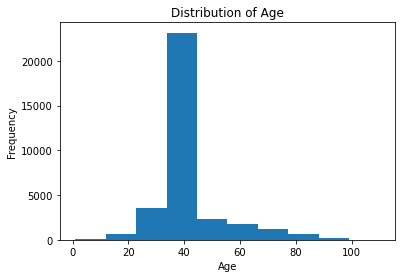

In [43]:
df['AGE'].plot.hist(bins=10)
plt.xlabel('Age')
plt.title('Distribution of Age')

Most of the constituency base is between the ages of 35-45. This is typically the early to mid-career point for many people so they are in their core earning years. This constituency base could be ready to have a qualification visit from a fundraiser to explore thier potential philanthropic interests as their wealth continues to increase.

### How many of the constiuents have weath ratings?

Text(0.5, 1.0, 'Distribution of Wealth Ratings')

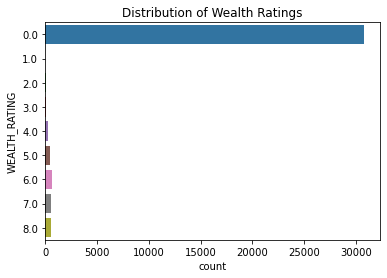

In [44]:
sns.countplot(y="WEALTH_RATING", data=df2)
plt.title('Distribution of Wealth Ratings')

As expected, most of the constiuents do not have wealth ratings. Of those that do have a rating, they are in the lower range of wealth at 6, which is a score that makes them capable of a gift of fifty to ninety-nine thousand dollars.

### How many constiuents have ever made a gift?

Text(0.5, 1.0, 'Distribution of Non-Donors vs. Past Donors')

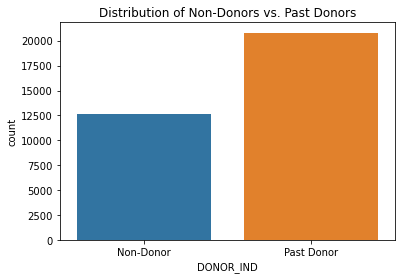

In [45]:
label_dict = {1: 'Past_Donor', 0: 'Non_Donor'}
sns.countplot(x='DONOR_IND', data=df2)
plt.xticks([0, 1], ['Non-Donor', 'Past Donor'])
plt.title('Distribution of Non-Donors vs. Past Donors')

The majority of the constiuent base have made a gift before to the institution. As this is anonymized data, the reason is unclear. Potentially, most constiuents were collected through a donation of some kind. Overall, the inclination to give again is high based on past giving.

### Exploring total giving

### What is the correlation of total giving and age?

Text(0.5, 1.0, 'Total Giving By Age')

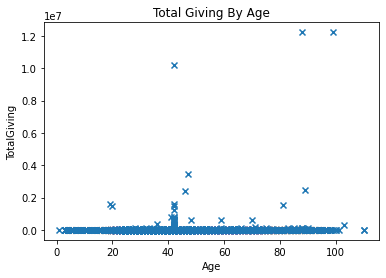

In [46]:
plt.scatter(x='AGE', y='TotalGiving', data=df2, marker='x')
plt.xlabel('Age')
plt.ylabel('TotalGiving')
plt.title('Total Giving By Age')

Two of the donors with the highest amount of total giving are avobe 80 years of age. However the 3rd highest total giving to the institution is in the 40s. As most people do not give, the correlation is hard to see in this graph.


### Let's explore this further by incorporating gender into this graph.

Text(0.5, 1.0, 'Total Giving By Age')

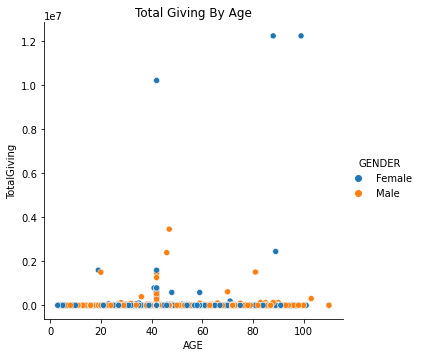

In [47]:
sns.relplot(x='AGE', y="TotalGiving", hue="GENDER", data=df)
plt.title('Total Giving By Age')

The top three highest donors are female to the institution.

### Now let's take a look at total giving by age.

Text(0.5, 1.0, 'Age By Wealth Rating')

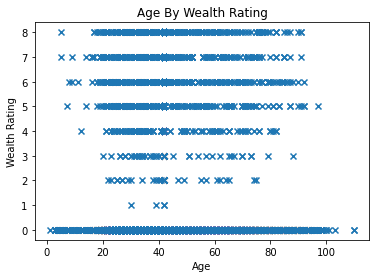

In [48]:
plt.scatter(x='AGE', y='WEALTH_RATING', data=df2, marker='x')
plt.xlabel('Age')
plt.ylabel('Wealth Rating')
plt.title('Age By Wealth Rating')

The most wealthy constiuents with a wealth rating of 1 are in the ages of 30-45.

### Let's take a look at thier gender.

Text(0.5, 1.0, 'Age By Wealth Rating')

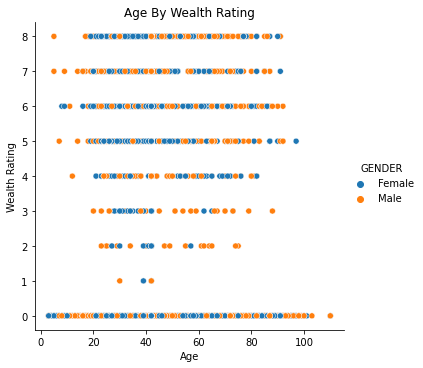

In [49]:
sns.relplot(x='AGE', y='WEALTH_RATING', hue="GENDER", data=df)
plt.xlabel('Age')
plt.ylabel('Wealth Rating')
plt.title('Age By Wealth Rating')

Two of the three known most wealthy constiuents are male. Let's take a look if they have ever donated to the institution.

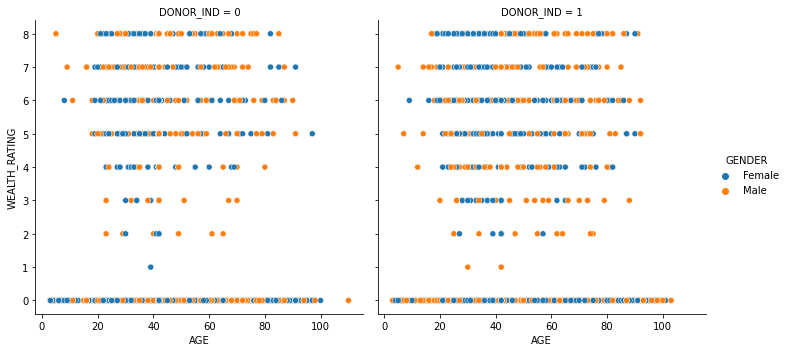

In [50]:
sns.relplot(x='AGE', y='WEALTH_RATING', hue="GENDER", col="DONOR_IND", data=df)


A graph shows that the highest total giving are from female donors. This graph shows that the wealthiest female consituents has not donated.

### How many consituents donated last year?

In [51]:
LastYrDonor = df2.loc[df2['PrevFYGiving'] != 0]

In [52]:
LastYrDonor

,AGE,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,EMAIL_PRESENT_IND,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,...,GENDER_Female,GENDER_Male,DEGREE_LEVEL_GC,DEGREE_LEVEL_GD,DEGREE_LEVEL_GM,DEGREE_LEVEL_GP,DEGREE_LEVEL_UB,DEGREE_LEVEL_UC,DEGREE_LEVEL_UG,CurrYrDonor
31,42.0,0,0,0,0.0,0,1,51,0,0,...,0,1,0,0,0,0,0,0,0,0
60,42.0,1,0,0,0.0,0,1,5000,0,0,...,0,1,0,0,0,0,1,0,0,0
85,32.0,1,0,0,0.0,0,0,20,0,0,...,0,1,0,0,0,0,0,0,0,0
97,42.0,0,0,0,0.0,1,3,120,0,0,...,1,0,0,0,0,0,0,0,0,0
108,79.0,0,0,0,0.0,0,1,25,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34473,25.0,0,1,0,0.0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
34475,42.0,0,0,0,0.0,0,8,1,0,0,...,1,0,0,0,0,0,0,0,0,0
34478,42.0,0,0,0,0.0,0,2,125,180,25,...,1,0,0,0,0,0,0,0,0,0
34497,25.0,1,0,1,0.0,1,0,1000,0,1000,...,1,0,0,0,0,0,1,0,0,0


There were a total of 2,289 consituents who made a gift last year.

### How many have donated so far?

In [53]:
CurrYrDonor = df2.loc[df2['CurrFYGiving'] > 0]

In [54]:
CurrYrDonor

,AGE,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,EMAIL_PRESENT_IND,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,...,GENDER_Female,GENDER_Male,DEGREE_LEVEL_GC,DEGREE_LEVEL_GD,DEGREE_LEVEL_GM,DEGREE_LEVEL_GP,DEGREE_LEVEL_UB,DEGREE_LEVEL_UC,DEGREE_LEVEL_UG,CurrYrDonor
2,42.0,0,0,0,0.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
19,42.0,0,1,0,0.0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
61,30.0,1,0,1,0.0,1,1,0,25,0,...,0,1,0,0,0,0,1,0,0,1
67,29.0,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
95,42.0,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34401,42.0,1,0,1,0.0,1,0,100,2,0,...,1,0,0,0,0,0,1,0,0,1
34415,41.0,1,0,0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
34425,42.0,0,0,0,0.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
34448,42.0,0,0,0,0.0,0,4,0,0,0,...,0,1,0,0,0,0,0,0,0,1


1,845 donors have so far donated this year.

### Are there any new donors to the institution? Are current year donors the same as last year?

In [55]:
New = df2.loc[(df2['PrevFYGiving'] == 0) & (df2['CurrFYGiving'] != 0)]

In [56]:
New

,AGE,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,EMAIL_PRESENT_IND,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,...,GENDER_Female,GENDER_Male,DEGREE_LEVEL_GC,DEGREE_LEVEL_GD,DEGREE_LEVEL_GM,DEGREE_LEVEL_GP,DEGREE_LEVEL_UB,DEGREE_LEVEL_UC,DEGREE_LEVEL_UG,CurrYrDonor
2,42.0,0,0,0,0.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
19,42.0,0,1,0,0.0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
61,30.0,1,0,1,0.0,1,1,0,25,0,...,0,1,0,0,0,0,1,0,0,1
67,29.0,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
95,42.0,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34373,42.0,0,0,1,0.0,0,1,0,0,130,...,1,0,0,0,0,0,0,0,0,1
34415,41.0,1,0,0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
34425,42.0,0,0,0,0.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
34448,42.0,0,0,0,0.0,0,4,0,0,0,...,0,1,0,0,0,0,0,0,0,1


There are 1,689 people that have donated this year but not last year.

### Correlations between features

<AxesSubplot:>

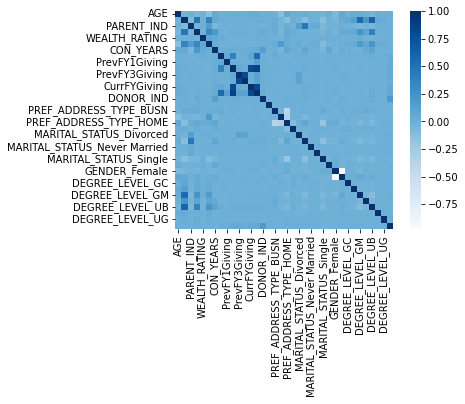

In [57]:
# correlation heatmap 
corrmat = df2.corr()
sns.heatmap(corrmat, square = True, cmap="Blues")

The highest correlated features are between the giving features.

Reviewing how current fiscal year giving correlates to other giving features:

Text(0.5, 0.98, 'Current Year Giving by Different Giving History')

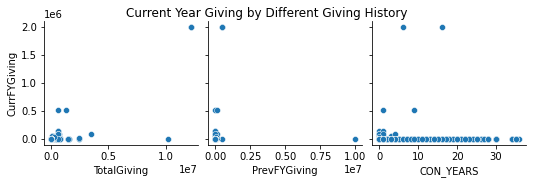

In [58]:
sns.pairplot(data=df2, y_vars=['CurrFYGiving'], x_vars=['TotalGiving', 'PrevFYGiving', 'CON_YEARS'])
plt.suptitle('Current Year Giving by Different Giving History')

### Reviewing how wealth rating correlates to giving features:

Text(0.5, 1.08, 'Wealth Rating by Different Giving History')

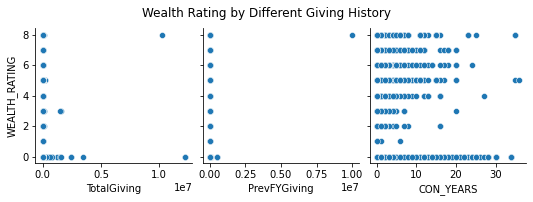

In [59]:
plot = sns.pairplot(data=df2, y_vars=['WEALTH_RATING'], x_vars=['TotalGiving', 'PrevFYGiving','CON_YEARS'])
plot.fig.suptitle('Wealth Rating by Different Giving History', y=1.08)

From the boxplot above there are some donors who have made sizeable gifts that have no wealth rating. This could be a discovery list to confirmm their capacity to donate. 

### Let's identify a discovery pool with anyone that is unrated and has total giving of over or equal to one hundred thousand. 

In [60]:
discovery = df2.loc[(df2['TotalGiving'] >= 100000) & (df2['WEALTH_RATING'] == 0)]

In [61]:
discovery

,AGE,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,EMAIL_PRESENT_IND,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,...,GENDER_Female,GENDER_Male,DEGREE_LEVEL_GC,DEGREE_LEVEL_GD,DEGREE_LEVEL_GM,DEGREE_LEVEL_GP,DEGREE_LEVEL_UB,DEGREE_LEVEL_UC,DEGREE_LEVEL_UG,CurrYrDonor
71,83.0,1,0,1,0.0,1,30,0,0,0,...,0,1,0,0,0,0,1,0,0,0
809,42.0,0,0,0,0.0,0,1,0,2500,0,...,1,0,0,0,0,0,0,0,0,0
1324,89.0,0,0,0,0.0,0,8,500000,1932960,3000,...,1,0,0,0,0,0,0,0,0,1
1792,90.0,0,0,1,0.0,0,15,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2172,99.0,1,0,1,0.0,0,6,500000,0,500000,...,1,0,0,0,1,0,0,0,0,1
2461,42.0,0,0,0,0.0,0,1,1630,0,500,...,1,0,0,0,0,0,0,0,0,0
2928,42.0,0,0,0,0.0,0,5,19505,5000,14555,...,0,1,0,0,0,0,0,0,0,0
3286,42.0,0,0,0,0.0,0,0,3000,53000,10400,...,1,0,0,0,0,0,0,0,0,1
3524,42.0,0,0,0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4276,41.0,0,0,0,0.0,0,0,0,25000,10000,...,1,0,0,0,0,0,0,0,0,1


There are 46 total that have total giving of $100,000 or more that have no wealth rating. This should be reviewed internally. The table above shows many that are in the age range where future gifts are possible. A wealth rating could help inform the strategic plan to cultivate them.

## 3. Prediction Models

#### Prepping predictor and target variables

Reviewing the features in the final dataframe to be potential predictor variables. I am removing features that contain giving information that could leak information on what our model is trying to predict such as total giving, consecutive years of giving, donor indicator, etc.

In [62]:
#Removing attributes that have giving information to avoid leakage to the data.
X = df2.drop(columns=['CurrFYGiving', 'TotalGiving', 'CON_YEARS', 'DONOR_IND', 'CurrYrDonor'])


The final list for prediction:

In [63]:
list(X.columns)

['AGE',
 'ALUMNUS_IND',
 'PARENT_IND',
 'HAS_INVOLVEMENT_IND',
 'WEALTH_RATING',
 'EMAIL_PRESENT_IND',
 'PrevFYGiving',
 'PrevFY1Giving',
 'PrevFY2Giving',
 'PrevFY3Giving',
 'PrevFY4Giving',
 'MalibuCA',
 'PREF_ADDRESS_TYPE_BUSN',
 'PREF_ADDRESS_TYPE_CAMP',
 'PREF_ADDRESS_TYPE_HOME',
 'PREF_ADDRESS_TYPE_OTR',
 'MARITAL_STATUS_Divorced',
 'MARITAL_STATUS_Married',
 'MARITAL_STATUS_Never Married',
 'MARITAL_STATUS_Separated',
 'MARITAL_STATUS_Single',
 'MARITAL_STATUS_Widowed',
 'GENDER_Female',
 'GENDER_Male',
 'DEGREE_LEVEL_GC',
 'DEGREE_LEVEL_GD',
 'DEGREE_LEVEL_GM',
 'DEGREE_LEVEL_GP',
 'DEGREE_LEVEL_UB',
 'DEGREE_LEVEL_UC',
 'DEGREE_LEVEL_UG']

The target variable will be a binary feature that was created. It is defined as 1 for made a git this year and 0 as has not made a gift this year.

In [64]:
y = df2['CurrYrDonor']

In [65]:
# checking sizes of variables are the same
X.shape

(33404, 31)

In [66]:
y.shape

(33404,)

In [67]:
y.value_counts()

0    31559
1     1845
Name: CurrYrDonor, dtype: int64

#### Check balance of classes

In [68]:
sum(y)/len(y)

0.0552329062387738

Class is imbalanced so stratify the data when splitting for train and test

#### Split the data for performance evaluation with 25% test size and stratified for imbalance.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [70]:
sum(y_train)/len(y_train)

0.05524288508362272

In [71]:
sum(y_test)/len(y_test)

0.055202969704227035

### Model #1: Logistic Regression

In [72]:
#inital model
lreg=sklm.LogisticRegression(solver='liblinear')
lreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [73]:
lreg_predictions_tr =lreg.predict(X_train)

In [74]:
#get the predicted probabilities in training:
lreg_predict_prob_tr=lreg.predict_proba(X_train) # predictions for training set as probability values
lreg_predict_prob_tr

array([[0.93807651, 0.06192349],
       [0.94011742, 0.05988258],
       [0.94588442, 0.05411558],
       ...,
       [0.94588193, 0.05411807],
       [0.94162545, 0.05837455],
       [0.93662491, 0.06337509]])

In [75]:
logit_result_tr = pd.DataFrame({'actual': y_train, 
                             'p(0)': [p[0] for p in lreg_predict_prob_tr],
                             'p(1)': [p[1] for p in lreg_predict_prob_tr],
                             'predicted': lreg_predictions_tr })
print("Predicted probabilities of training data")
logit_result_tr

Predicted probabilities of training data


,actual,p(0),p(1),predicted
10104,0,0.938077,0.061923,0
32638,0,0.940117,0.059883,0
3968,0,0.945884,0.054116,0
9191,0,0.946308,0.053692,0
17620,1,0.950097,0.049903,0
...,...,...,...,...
5717,0,0.935868,0.064132,0
26072,0,0.945751,0.054249,0
4898,0,0.945882,0.054118,0
9023,0,0.941625,0.058375,0


In [76]:
print("Highest probability of being a donor from training data")

logit_result_tr.sort_values(by='p(1)', ascending=False).head()

Highest probability of being a donor from training data


,actual,p(0),p(1),predicted
18404,1,0.000000e+00,1.000000,1
1324,1,0.000000e+00,1.000000,1
2172,1,3.064216e-14,1.000000,1
34056,1,1.152034e-11,1.000000,1
33186,1,3.741596e-03,0.996258,1


In [77]:
print("Lowest probability of being a donor from training data")
logit_result_tr.sort_values(by='p(1)').head()

Lowest probability of being a donor from training data


,actual,p(0),p(1),predicted
6371,0,0.985506,0.014494,0
26034,0,0.969292,0.030708,0
3432,0,0.968079,0.031921,0
20547,0,0.968072,0.031928,0
2725,0,0.967633,0.032367,0


Text(0.5, 1.0, 'Confusion matrix of lreg on train')

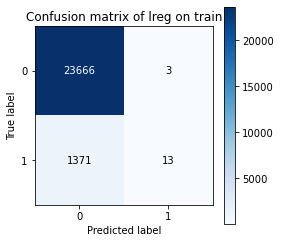

In [78]:
skplt.metrics.plot_confusion_matrix(y_train, lreg_predictions_tr, figsize=(4,4), cmap="Blues")
plt.title('Confusion matrix of lreg on train')

In [79]:
#classification report for training
print("Classification Report for lreg train:\n",classification_report(y_train, lreg_predictions_tr))

Classification Report for lreg train:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     23669
           1       0.81      0.01      0.02      1384

    accuracy                           0.95     25053
   macro avg       0.88      0.50      0.50     25053
weighted avg       0.94      0.95      0.92     25053



In [80]:
#Performance on test data
lreg_predictions_tt=lreg.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix of lreg on test')

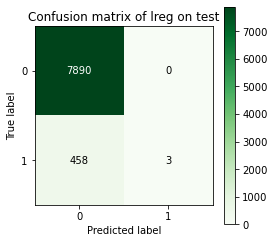

In [81]:
skplt.metrics.plot_confusion_matrix(y_test, lreg_predictions_tt, figsize=(4,4), cmap="Greens")
plt.title('Confusion matrix of lreg on test')

In [82]:
print("Classification Report for lreg test:\n",classification_report(y_test, lreg_predictions_tt))


Classification Report for lreg test:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      7890
           1       1.00      0.01      0.01       461

    accuracy                           0.95      8351
   macro avg       0.97      0.50      0.49      8351
weighted avg       0.95      0.95      0.92      8351



Performance of model on test model is much lower than on train data.

#### Lowering the probability for model from default of 50% to 5% to see if the model is able to capture more donors.

In [83]:
probabilities = lreg.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'Confusion matrix of 5% lreg on test')

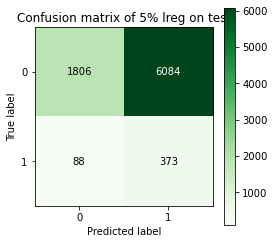

In [84]:
prediction = probabilities > 0.05

skplt.metrics.plot_confusion_matrix(y_test, prediction, figsize=(4,4), cmap="Greens")
plt.title('Confusion matrix of 5% lreg on test')

In [85]:
print("Classification Report of 5% lreg on test:\n",classification_report(y_test, prediction))

Classification Report of 5% lreg on test:
               precision    recall  f1-score   support

           0       0.95      0.23      0.37      7890
           1       0.06      0.81      0.11       461

    accuracy                           0.26      8351
   macro avg       0.51      0.52      0.24      8351
weighted avg       0.90      0.26      0.35      8351



At 5% probability, the model makes many more mistakes on who is a donor but it also correctly identifies 367 donors. This could be preferable to capture potential donors. There should be a review on the negative effects of soliciting a donor that is unlikely to donate.

#### Adding a penalty and cross-validation to see if model can be improved.

L1

In [86]:
# regularization
logitcv = sklm.LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logitcv.fit(X_train, y_train)

LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear')

Text(0.5, 1.0, 'Confusion matrix of l1 lreg')

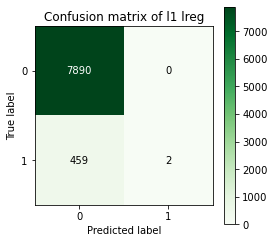

In [87]:
skplt.metrics.plot_confusion_matrix(y_test, logitcv.predict(X_test), figsize=(4,4), cmap="Greens")
plt.title('Confusion matrix of l1 lreg')

There is no improvement from the original model.

#### Nominal Logit

In [88]:
nlogit = sklm.LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
nlogit.fit(X, y)

LogisticRegression(C=1e+24, multi_class='multinomial')

In [89]:
probs = nlogit.predict_proba(X)

Text(0.5, 1.0, 'Confusion matrix of l2 lreg')

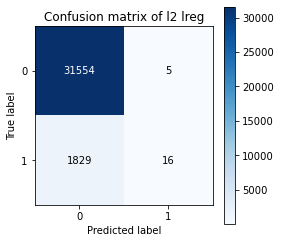

In [90]:
skplt.metrics.plot_confusion_matrix(y, nlogit.predict(X), figsize=(4,4), cmap="Blues")
plt.title('Confusion matrix of l2 lreg')

In [91]:
print("Classification Report:\n",classification_report(y, nlogit.predict(X), zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     31559
           1       0.76      0.01      0.02      1845

    accuracy                           0.95     33404
   macro avg       0.85      0.50      0.49     33404
weighted avg       0.94      0.95      0.92     33404



### Model #2: KNN

In [92]:
# we scale the Xvar before using KNN:
X=preprocessing.scale(X)

In [93]:
# Set aside 25% of data for out-of-training-sample test:
X3pc_train, X3pc_test, Y3pc_train, Y3pc_test = train_test_split(X, y, \
                                                           test_size=0.25, random_state=7)
print(X3pc_train.shape, Y3pc_train.shape)
print(X3pc_test.shape, Y3pc_test.shape)

(25053, 31) (25053,)
(8351, 31) (8351,)


In [94]:
# Specify the parameters of the KNN classifer:
knn_ccv = KNeighborsClassifier(n_neighbors=4, weights='uniform') # considering 4 nearest neighbors weighted equally

In [95]:
# Fit the KNN model with training data:
knn_ccv.fit(X3pc_train, Y3pc_train)

KNeighborsClassifier(n_neighbors=4)

In [96]:
# Get the prediction of the KNN training
knn_prediction_ctr=knn_ccv.predict(X3pc_train)

Text(0.5, 1.0, 'Confusion matrix of knn train')

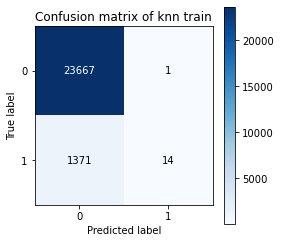

In [97]:
skplt.metrics.plot_confusion_matrix(Y3pc_train, knn_prediction_ctr, figsize=(4,4), cmap="Blues")
plt.title('Confusion matrix of knn train')

In [98]:
# Evaluate how good the knn classification of training data is:
cm_knn = confusion_matrix(Y3pc_train, knn_prediction_ctr)

print("Classification Report of knn train:\n",classification_report(Y3pc_train, knn_prediction_ctr))

Classification Report of knn train:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     23668
           1       0.93      0.01      0.02      1385

    accuracy                           0.95     25053
   macro avg       0.94      0.51      0.50     25053
weighted avg       0.94      0.95      0.92     25053



In [99]:
# Evaluate how good the knn classification, after cross-validation:
cvparam = KFold(3, random_state=13, shuffle=True)
scores_accuracy_knn =  cross_val_score(knn_ccv, X3pc_train, Y3pc_train, cv=cvparam, scoring='accuracy')

In [100]:
scores_accuracy_knn.mean() #average training accuracy

0.9447171995369815

In [101]:
# How good is the trained model for predicting the test data?
knn_prediction_ctr_tt=knn_ccv.predict(X3pc_test) #use test data

Text(0.5, 1.0, 'Confusion matrix of knn test')

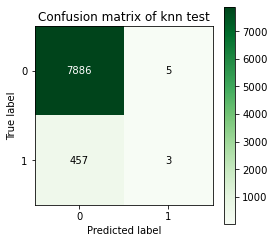

In [102]:
skplt.metrics.plot_confusion_matrix(Y3pc_test, knn_prediction_ctr_tt, figsize=(4,4), cmap="Greens")
plt.title('Confusion matrix of knn test')

In [103]:
# Evaluate how good the knn classification of training data is:
cm_knn_tt = confusion_matrix(Y3pc_test, knn_prediction_ctr_tt)
print("Classification Report knn on test:\n",classification_report(Y3pc_test, knn_prediction_ctr_tt))

Classification Report knn on test:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      7891
           1       0.38      0.01      0.01       460

    accuracy                           0.94      8351
   macro avg       0.66      0.50      0.49      8351
weighted avg       0.91      0.94      0.92      8351



### Model #3: XGBoost

In [104]:
#hyper parameter optimization

params = {
     'max_depth': [1, 2, 3, 4, 5],
     'learning_rate': [0.1, 0.01, 0.05],
     'min_child_weight': [1, 3, 5, 7],
     'colsample_bytree': [ 0.3, 0.4, 0.5, 0.7],
     'gamma': [0, 0.25, 1.0, 1.5],
     'reg_lambda': [0, 1.0, 10.0],
     'scale_pos_weight': [1, 3, 5, 7] # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
 }

In [105]:
def timer(start_time=None):
    if not start_time:
        start_time =datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [106]:
classifier=xgboost.XGBClassifier(objective='binary:logistic')

In [107]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3, random_state=42)

In [108]:
from datetime import datetime

start_time=timer(None)
random_search.fit(X,y)
timer(start_time)


Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 0 minutes and 9.3 seconds.


In [109]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [110]:
random_search.best_params_

{'scale_pos_weight': 7,
 'reg_lambda': 1.0,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.4}

In [111]:
clf_xgb=xgb.XGBClassifier(seed=42,
                          objective='binary:logistic',
                          gamma=1.5,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=1.0,
                          scale_pos_weight=7,
                          subsample=0.9,
                          colsample_bytree=0.4,
                          use_label_encoder=False)

clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.05889
[1]	validation_0-aucpr:0.06286
[2]	validation_0-aucpr:0.06527
[3]	validation_0-aucpr:0.06729
[4]	validation_0-aucpr:0.07043
[5]	validation_0-aucpr:0.07090
[6]	validation_0-aucpr:0.07109
[7]	validation_0-aucpr:0.07312
[8]	validation_0-aucpr:0.07476
[9]	validation_0-aucpr:0.07441
[10]	validation_0-aucpr:0.07525
[11]	validation_0-aucpr:0.07660
[12]	validation_0-aucpr:0.07717
[13]	validation_0-aucpr:0.07653


C:\Users\dsemi\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\dsemi\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\dsemi\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-aucpr:0.07655
[15]	validation_0-aucpr:0.07680
[16]	validation_0-aucpr:0.07664
[17]	validation_0-aucpr:0.07667
[18]	validation_0-aucpr:0.07631
[19]	validation_0-aucpr:0.07512
[20]	validation_0-aucpr:0.07479
[21]	validation_0-aucpr:0.07605


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

Text(0.5, 1.0, 'Confusion matrix of XGB train')

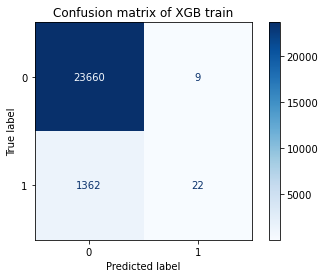

In [112]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf_xgb, 
                      X_train, 
                      y_train,
                      cmap=plt.cm.Blues)
plt.title('Confusion matrix of XGB train')

Text(0.5, 1.0, 'Confusion matrix of XGB test')

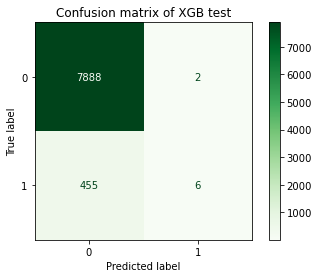

In [113]:
y_pred = clf_xgb.predict(X_test)

ConfusionMatrixDisplay.from_predictions( 
                      y_test, 
                      y_pred,
                      values_format='d',
                      cmap=plt.cm.Greens)
plt.title('Confusion matrix of XGB test')

In [114]:
import shap
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


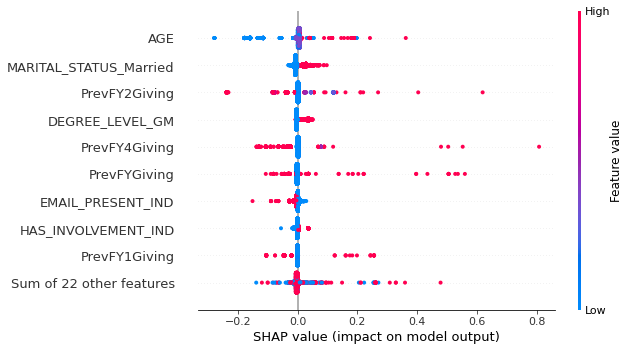

In [115]:
shap.plots.beeswarm(shap_values)

#### Evaluating all the models

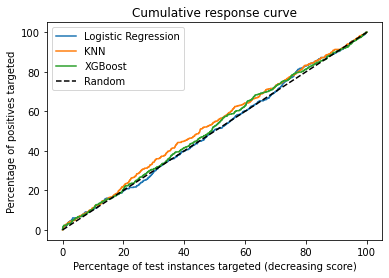

In [116]:
def build_cumulative_curve(model, scale=100):
    # Fit model
    model.fit(X_train, y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Sort theseprobabilities and the true value in descending order of probability
    order = np.argsort(Y_test_probability_1)[::-1]
    Y_test_probability_1_sorted = Y_test_probability_1[order]
    Y_test_sorted = np.array(y_test)[order]

    # Build the cumulative response curve
    x_cumulative = np.arange(len(Y_test_probability_1_sorted)) + 1
    y_cumulative = np.cumsum(Y_test_sorted)

    # Rescale
    x_cumulative = np.array(x_cumulative)/float(x_cumulative.max()) * scale
    y_cumulative = np.array(y_cumulative)/float(y_cumulative.max()) * scale
    
    return x_cumulative, y_cumulative

def plot_cumulative_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [0,100], 'k--', label="Random")
    plt.xlabel("Percentage of test instances targeted (decreasing score)")
    plt.ylabel("Percentage of positives targeted")
    plt.title("Cumulative response curve")
    plt.legend()

models = {"Logistic Regression": lreg,
          "KNN": knn_ccv,
          "XGBoost": clf_xgb}
plot_cumulative_curve(models)

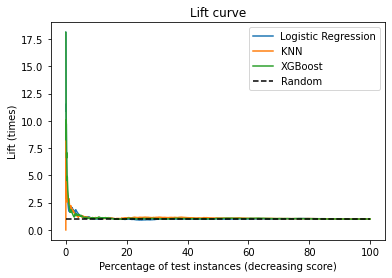

In [117]:
def plot_lift_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative/x_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [1,1], 'k--', label="Random")
    plt.xlabel("Percentage of test instances (decreasing score)")
    plt.ylabel("Lift (times)")
    plt.title("Lift curve")
    plt.legend()

plot_lift_curve(models)

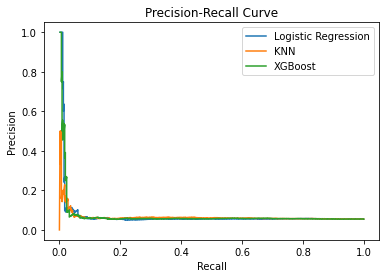

In [119]:
def build_pr_curve(model):
    # Fit model
    model.fit(X_train, y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Sort these probabilities and the true value in descending order of probability
    order = np.argsort(Y_test_probability_1)[::-1]
    Y_test_probability_1_sorted = Y_test_probability_1[order]
    Y_test_sorted = np.array(y_test)[order]

    # Build the precision-recall curve
    precision_curve = []
    recall_curve = []
    num_positives = np.sum(Y_test_sorted)
    true_positives = 0
    for i in range(len(Y_test_sorted)):
        if Y_test_sorted[i] == 1:
            true_positives += 1
        precision = true_positives / float(i+1)
        recall = true_positives / float(num_positives)
        precision_curve.append(precision)
        recall_curve.append(recall)

    return precision_curve, recall_curve

def plot_pr_curve(models):
    # Plot curve for each model
    for key in models:
        precision_curve, recall_curve = build_pr_curve(models[key])
        plt.plot(recall_curve, precision_curve, label=key)

    # Plot other details
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

models = {"Logistic Regression": lreg,
          "KNN": knn_ccv,
          "XGBoost": clf_xgb}

plot_pr_curve(models)

## 4. Summary

### Some key takeaways

From the data prepartion stage, this anonymized dataset is from an instituion where a majority of the constiuents were densely located in Malibu, CA. The dataset tracks membership, alumnus, parent, and involvement indicators. The majority of the 34,000 rows of data are not members, alumni, parent, or involved. There's an even split between male and female constiuents and the majority are married.

Analyzing the data further, most of the constituents are between the ages of 35-45. Nearly 2/3 of the constituents have made a gift in the past and are identified as a donor. Some of the highest total giving at the institution are from those in the ages of 35-45. The highest donors are female with total giving over $1M. Male consituents with a wealth rating of 1 have previously made a gift to the institution while the wealthest female consituent has not made a donation.

At the time of this data collection, the institutions has eighty percent of the donors that it does from last year with 1,689 new donors from last year. This churn is high and implicates that predicting returning donors could be difficult.

There is an opportunity to rate donors who have already given to the institution by identifying those with high giving and no wealth rating. This will help inform the strategic plan to cultivate these donors further.

### Predicting donors 

Predicting current year donors with the available features was a difficult task given the imbalance of donors to non-donors.

While most models were overall accurate at 94%+ on average, they all failed to appropriately identified donors by mostly classifying everyone as a non-donor. This proved even more difficult when testing generalization on the test dataset.

Sacrificing overall accuracy, a logistic regression with a lower probability could identify more true donors but misclassifying non-donors as donors. A overall cuttoff and cost benefit analysis could help determine if this model would be helpful in outreach such as mailings, event invitations, calls, or visits from fundraisers.

### Limitations

Given the poor performance of the models to predict donors, more data and information especially around past giving could be helpful as the giving features were the highest correlated variables. The challenge with this classification task will continue to be the imbalance of the dataset. With a larger dataset, the model could also have a better opportunity to learn  patterns that increase performance to correctly classify donors.